In [2]:
!git clone https://github.com/teamght/mascotas-model-app
!mv mascotas-model-app/saved_model ./saved_model

Cloning into 'mascotas-model-app'...
remote: Enumerating objects: 7951, done.
remote: Counting objects: 100% (183/183), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 7951 (delta 114), reused 169 (delta 101), pack-reused 7768
Receiving objects: 100% (7951/7951), 258.62 MiB | 36.18 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [3]:
!ls saved_model
!ls saved_model/variables

model_configuracion.py	online_training.py  saved_model.pb
offline_training.py	predict.py	    variables
variables.data-00000-of-00001  variables.index


In [4]:
# LOADING MODEL

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import tensorflow as tf

import os
import numpy as np
import skimage as sk
from skimage import io
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K


PATH        = 'dogs-dataset-b-limpio/data/' # Path to the directory of the saved dataset
PATH_MODEL  = './saved_model'      # Path to the directory where the model will be stored
SIZE        = (224,224,3)                               # Size of the input images


#----------------------------------------------------------------------------
# Loss definition.

alpha = 0.3
def triplet(y_true,y_pred):
    
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)

    return K.sum(tf.nn.relu(ap - an + alpha))

def triplet_acc(y_true,y_pred):
    a = y_pred[0::3]
    p = y_pred[1::3]
    n = y_pred[2::3]
    
    ap = K.sum(K.square(a-p),-1)
    an = K.sum(K.square(a-n),-1)
    
    return K.less(ap+alpha,an)

#----------------------------------------------------------------------------
# Model load

print('Loading model...')

model = tf.keras.models.load_model(PATH_MODEL,
    custom_objects={'triplet':triplet,'triplet_acc':triplet_acc})

print('Done')


Loading model...
Done


In [5]:
!git clone -b datasets_limpios_alineados https://gitlab.com/teamghtgcba/dogs-dataset-b-limpio.git

Cloning into 'dogs-dataset-b-limpio'...
remote: Enumerating objects: 60735, done.
remote: Counting objects: 100% (60735/60735), done.
remote: Compressing objects: 100% (60701/60701), done.
remote: Total 60735 (delta 9), reused 60730 (delta 4), pack-reused 0
Receiving objects: 100% (60735/60735), 908.05 MiB | 44.19 MiB/s, done.
Resolving deltas: 100% (9/9), done.
Checking out files: 100% (41169/41169), done.


In [6]:
#!ls dogs-dataset-b-limpio/data/

assert os.path.isdir(PATH), '[Error] Provided PATH for dataset does not exist.'

In [7]:
print('Loading the dataset...')

import os, random
carpetas = sorted([o for o in os.listdir(PATH) if os.path.isdir(os.path.join(PATH, o))])
random.seed(4)
random.shuffle(carpetas)
print(carpetas[:10])

carpetas2 = [(PATH + c, None, os.listdir(os.path.join(PATH, c))) for c in carpetas]

filenames = np.empty(0)
labels = np.empty(0)
idx = 0
for root, dirs, files in carpetas2:
    # Directorio / / archivos por directorio (list())
    #print('{} {} {}'.format(root,dirs,files))
    if len(files)>1:
        for i in range(len(files)):
            files[i] = root + '/' + files[i]
        filenames = np.append(filenames,files)
        # Recupera la ruta de todos los archivos
        #print('{}'.format(filenames))
        labels = np.append(labels,np.ones(len(files))*idx)
        # Crea una lista de etiquetas "nombre de las carpetas". Posteriormente se obtendrá las etiquetas únicas
        #print('{}'.format(labels))
        idx += 1

print(filenames)
print(labels)

Loading the dataset...
['50430193', '51293014', '51070822', '51236085', '51298788', '1301', '51286528', '50894180', '51217312', '51202526']
['dogs-dataset-b-limpio/data/50430193/4.jpg'
 'dogs-dataset-b-limpio/data/50430193/2.jpg'
 'dogs-dataset-b-limpio/data/50430193/3.jpg' ...
 'dogs-dataset-b-limpio/data/50556157/1.jpg'
 'dogs-dataset-b-limpio/data/50138359/0.jpg'
 'dogs-dataset-b-limpio/data/50138359/1.jpg']
[    0.     0.     0. ... 12475. 12476. 12476.]


In [8]:
TEST_SPLIT  = 0.05                                       # Test ratio
VAL_SPLIT  = 0.05                                       # Val ratio


print('Total number of imported pictures: {:d}'.format(len(labels)))
nbof_classes = len(np.unique(labels))
print('Total number of classes: {:d}'.format(nbof_classes))

# Split the dataset.
print('\nSplit por las clases de perros que se tienen, no por las imágenes')

nbof_test = int(TEST_SPLIT*nbof_classes)
nbof_val = int(VAL_SPLIT*nbof_classes)

keep_test = np.less(labels, nbof_test) # 111 0000000000000
keep_val_1 = np.greater_equal(labels, nbof_test) # 000 1111111111111
keep_val_2 = np.less(labels, nbof_test + nbof_val) # 1111111111111 000000
keep_val = np.logical_and(keep_val_1, keep_val_2) # 000 1111111111 000000
keep_train = np.greater_equal(labels, nbof_test + nbof_val) # 000000000 1111
'''
print(keep_test)
print(keep_val)
print(keep_train)
print(np.sum(keep_test), np.sum(keep_val), np.sum(keep_train))
'''

filenames_test = filenames[keep_test]
labels_test = labels[keep_test]

filenames_train = filenames[keep_train]
labels_train = labels[keep_train]

filenames_val = filenames[keep_val]
labels_val = labels[keep_val]

print("Number of training data: {} pictures".format(str(len(filenames_train))))
print("Number of training classes: {} ({} %)".format(str(nbof_classes-nbof_test-nbof_val), 1 - TEST_SPLIT - VAL_SPLIT))
print("Number of testing data: {} pictures".format(str(len(filenames_test))))
print("Number of testing classes: {} ({} %)".format(str(nbof_test), TEST_SPLIT))
print("Number of validation data: {} pictures".format(str(len(filenames_val))))
print("Number of validation classes: {} ({} %)".format(str(nbof_val), VAL_SPLIT))

Total number of imported pictures: 41142
Total number of classes: 12477

Split por las clases de perros que se tienen, no por las imágenes
Number of training data: 37110 pictures
Number of training classes: 11231 (0.8999999999999999 %)
Number of testing data: 2025 pictures
Number of testing classes: 623 (0.05 %)
Number of validation data: 2007 pictures
Number of validation classes: 623 (0.05 %)


In [9]:
print(filenames_test)
print(labels_test)

['dogs-dataset-b-limpio/data/50430193/4.jpg'
 'dogs-dataset-b-limpio/data/50430193/2.jpg'
 'dogs-dataset-b-limpio/data/50430193/3.jpg' ...
 'dogs-dataset-b-limpio/data/51156646/3.jpg'
 'dogs-dataset-b-limpio/data/51156646/5.jpg'
 'dogs-dataset-b-limpio/data/51156646/1.jpg']
[  0.   0.   0. ... 622. 622. 622.]


In [10]:

def load_images(filenames):
    """
    Use scikit-image library to load the pictures from files to numpy array.
    """
    h,w,c = SIZE
    images = np.empty((len(filenames),h,w,c))
    for i,f in enumerate(filenames):
        images[i] = sk.io.imread(f)/255.0
    return images

def predict_generator(filenames, batch_size=32):
    """
    Prediction generator.
    """
    for i in range(0,len(filenames),batch_size):
        print(f'predict_generator: {i} de {len(filenames)}')
        images_batch = load_images(filenames[i:i+batch_size])
        yield images_batch


In [11]:
## CORRER RED SOBRE TODAS LAS IMÁGENES

pairs = list(filenames_test)
#pairs = list(filenames_val)

predict = model.predict_generator(predict_generator(pairs, 32), steps=np.ceil(len(pairs)/32))


predict_generator: 0 de 2025


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


predict_generator: 32 de 2025
predict_generator: 64 de 2025
predict_generator: 96 de 2025
predict_generator: 128 de 2025
predict_generator: 160 de 2025
predict_generator: 192 de 2025
predict_generator: 224 de 2025
predict_generator: 256 de 2025
predict_generator: 288 de 2025
predict_generator: 320 de 2025
predict_generator: 352 de 2025
predict_generator: 384 de 2025
predict_generator: 416 de 2025
predict_generator: 448 de 2025
predict_generator: 480 de 2025
predict_generator: 512 de 2025
predict_generator: 544 de 2025
predict_generator: 576 de 2025
predict_generator: 608 de 2025
predict_generator: 640 de 2025
predict_generator: 672 de 2025
predict_generator: 704 de 2025
predict_generator: 736 de 2025
predict_generator: 768 de 2025
predict_generator: 800 de 2025
predict_generator: 832 de 2025
predict_generator: 864 de 2025
predict_generator: 896 de 2025
predict_generator: 928 de 2025
predict_generator: 960 de 2025
predict_generator: 992 de 2025
predict_generator: 1024 de 2025
predict_ge

In [12]:
predictions_list = list(predict)
labels_list = [int(label) for label in labels_test]

In [13]:
def distance(v1, v2):
  diff = np.square(v1-v2)
  dist = np.sum(diff)
  return dist

In [14]:
pairs_same_class = []
pairs_different_class = []
for i1, (p1, l1) in enumerate(zip(predictions_list, labels_list)):
  for i2, (p2, l2) in enumerate(zip(predictions_list, labels_list)):
    d = distance(p1, p2)
    pair = (i1, p1, l1, i2, p2, l2, d)
    if i1 < i2:
      if l1 == l2:
          pairs_same_class.append(pair)
      else:
          pairs_different_class.append(pair)
print("len(pairs_same_class):", len(pairs_same_class))
print("len(pairs_different_class):", len(pairs_different_class))

len(pairs_same_class): 2828
len(pairs_different_class): 2046472


In [15]:
def leave_only_sorted_distances(pairs):
  distances = [p[6] for p in pairs]
  distances.sort()
  return distances

distances_same_class = leave_only_sorted_distances(pairs_same_class)
distances_different_class = leave_only_sorted_distances(pairs_different_class)

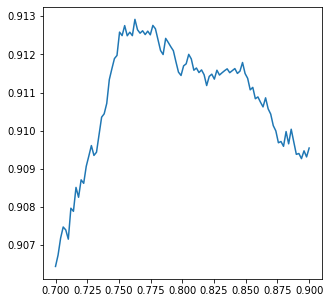

Threshold with max accuracy: 0.7626262626262627
Max accuracy: 0.9129170717220326


In [16]:
def count_less(l, threshold):
  total = len(l)
  for i in range(total):
    if l[i] >= threshold:
      return (i, total-i)
  return (total, 0)

def draw_thresholds(thresholds):
  accuracies = []
  for threshold in thresholds:
    tp, fn = count_less(distances_same_class, threshold)
    fp, tn = count_less(distances_different_class, threshold)
    acc_diff_class = 1. * tp / (tp+fn)
    acc_same_class = 1. * tn / (tn+fp)
    acc = (acc_diff_class+acc_same_class)/2
    #print(f"tp={tp}, fn={fn}, fp={fp}, tn={tn}, acc={acc}")
    #print(threshold, acc)
    accuracies.append((threshold, acc))

  ts, accs = zip(*accuracies)

  fig = plt.figure(figsize=(5, 5))
  ax = fig.add_subplot(1, 1, 1)
  plt.plot(ts, accs)
  plt.show()

  best_threshold, best_acc = sorted(accuracies, key=lambda x: x[1], reverse=True)[0]
  print("Threshold with max accuracy:", best_threshold)
  print("Max accuracy:", best_acc)

  return best_threshold

#threshold = draw_thresholds(np.linspace(0, 1.25, 20))
# Threshold with max accuracy: 0.7894736842105263; Max accuracy: 0.9123999952796951

threshold = draw_thresholds(np.linspace(0.7, 0.9, 100)) # Threshold with max accuracy: 0.7626262626262627; Max accuracy: 0.9129170717220326

### BEST THRESHOLD: 0.76262626 ###


In [20]:
tp, fn = count_less(distances_same_class, threshold)
fp, tn = count_less(distances_different_class, threshold)
acc_diff_class = 1. * tp / (tp+fn)
acc_same_class = 1. * tn / (tn+fp)
acc = (acc_diff_class+acc_same_class)/2

print(f"tp={tp}, fn={fn}, fp={fp}, tn={tn}, acc={acc}")
print()

print(f"\tPred_P\tPred_N\nReal_P\t{tp}\t{fn}\nReal_N\t{fp}\t{tn}")
print()

same_dog_percentage = '{:.2f}'.format(acc_same_class*100)
different_dog_percentage = '{:.2f}'.format(acc_diff_class*100)
print(f"Para el grupo mismo-perro (positivo) la red predijo positivo el {same_dog_percentage}% de las veces.")
print(f"Para el grupo distinto-perro (negativo) la red predijo negativo el {different_dog_percentage}% de las veces.")

tp=2592, fn=236, fp=185645, tn=1860827, acc=0.9129170717220326

	Pred_P	Pred_N
Real_P	2592	236
Real_N	185645	1860827

Para el grupo mismo-perro (positivo) la red predijo positivo el 90.93% de las veces.
Para el grupo distinto-perro (negativo) la red predijo negativo el 91.65% de las veces.
